In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# --- CONFIGURACIÓN ---
# Asegúrate de que estas rutas coincidan con tu entorno
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
AAL3_TXT_PATH = DATA_DIR / "ROI_MNI_V7_vol.txt"
OUTPUT_CSV_PATH = DATA_DIR / "aal3_131_manual_network_order.csv"

# --- 1. DICCIONARIO MAESTRO DE CONSENSO (AAL3 -> YEO17) ---
# Clave: Inicio del nombre corto (nom_c) de AAL3.
# Valor: Tupla (ID_Red_Yeo, Nombre_Red_Yeo)
# Estrategia para CNN: Agrupar visual/motor al inicio, cognitivo al medio, subcortical al final.

YEO_MAPPING = {
    # --- VISUAL (Yeo 1 & 2) ---
    'V1': (2, 'Visual_Central'), 'Calcarine': (2, 'Visual_Central'),
    'O1': (1, 'Visual_Peripheral'), 'Occipital_Sup': (1, 'Visual_Peripheral'),
    'O2': (1, 'Visual_Peripheral'), 'Occipital_Mid': (1, 'Visual_Peripheral'),
    'O3': (1, 'Visual_Peripheral'), 'Occipital_Inf': (1, 'Visual_Peripheral'),
    'LING': (1, 'Visual_Peripheral'), 'Lingual': (1, 'Visual_Peripheral'),
    'Q': (1, 'Visual_Peripheral'), 'Cuneus': (1, 'Visual_Peripheral'),
    'FUSI': (1, 'Visual_Peripheral'), 'Fusiform': (1, 'Visual_Peripheral'),

    # --- SOMATOMOTOR (Yeo 3 & 4) ---
    'FA': (3, 'Somatomotor_A'), 'Precentral': (3, 'Somatomotor_A'), # Motor
    'PA': (3, 'Somatomotor_A'), 'Postcentral': (3, 'Somatomotor_A'), # Sensitivo
    'SMA': (3, 'Somatomotor_A'), 'Supp_Motor_Area': (3, 'Somatomotor_A'),
    'LPC': (3, 'Somatomotor_A'), 'Paracentral_Lobule': (3, 'Somatomotor_A'),
    'T1': (4, 'Somatomotor_B'), 'Temporal_Sup': (4, 'Somatomotor_B'), # Auditivo
    'HESCHL': (4, 'Somatomotor_B'), 'Heschl': (4, 'Somatomotor_B'), # Auditivo primario
    'OR': (4, 'Somatomotor_B'), 'Rolandic_Oper': (4, 'Somatomotor_B'),

    # --- DORSAL ATTENTION (Yeo 5 & 6) ---
    'P1': (5, 'DorsalAttention_A'), 'Parietal_Sup': (5, 'DorsalAttention_A'),
    'O2': (6, 'DorsalAttention_B'), # A veces overlap aquí, pero lo dejamos en visual por anatomía

    # --- SALIENCE / VENTRAL ATTENTION (Yeo 7 & 8) ---
    'IN': (7, 'Salience_VentralAttention_A'), 'Insula': (7, 'Salience_VentralAttention_A'),
    'CINM': (7, 'Salience_VentralAttention_A'), 'Cingulate_Mid': (7, 'Salience_VentralAttention_A'),
    'F3OP': (8, 'Salience_VentralAttention_B'), 'Frontal_Inf_Oper': (8, 'Salience_VentralAttention_B'),
    'GSM': (8, 'Salience_VentralAttention_B'), 'SupraMarginal': (8, 'Salience_VentralAttention_B'),

    # --- LIMBIC (Yeo 9 & 10) - CRÍTICO PARA ALZHEIMER ---
    # Red 9: Polo Temporal / Límbico "Memoria/Emoción"
    'HIPP': (9, 'Limbic_A_TempPole'), 'Hippocampus': (9, 'Limbic_A_TempPole'),
    'PARA_HIPP': (9, 'Limbic_A_TempPole'), 'ParaHippocampal': (9, 'Limbic_A_TempPole'),
    'AMYG': (9, 'Limbic_A_TempPole'), 'Amygdala': (9, 'Limbic_A_TempPole'),
    'T1A': (9, 'Limbic_A_TempPole'), 'Temporal_Pole_Sup': (9, 'Limbic_A_TempPole'),
    'T2A': (9, 'Limbic_A_TempPole'), 'Temporal_Pole_Mid': (9, 'Limbic_A_TempPole'),
    'T3': (9, 'Limbic_A_TempPole'), 'Temporal_Inf': (9, 'Limbic_A_TempPole'), # A veces Visual, pero en AD su atrofia es clave

    # Red 10: Orbitofrontal (OFC) "Reward/Decision"
    'OFC': (10, 'Limbic_B_OFC'), 
    'GR': (10, 'Limbic_B_OFC'), 'Rectus': (10, 'Limbic_B_OFC'),
    'COB': (10, 'Limbic_B_OFC'), 'Olfactory': (10, 'Limbic_B_OFC'),
    'FMO': (10, 'Limbic_B_OFC'), 'Frontal_Med_Orb': (10, 'Limbic_B_OFC'),

    # --- CONTROL (Yeo 11, 12, 13) ---
    'F2': (12, 'Control_A'), 'Frontal_Mid': (12, 'Control_A'), # DLPFC approx
    'F3T': (12, 'Control_A'), 'Frontal_Inf_Tri': (12, 'Control_A'),
    'P2': (13, 'Control_B'), 'Parietal_Inf': (13, 'Control_B'),
    'F1': (13, 'Control_B'), 'Frontal_Sup': (13, 'Control_B'), # A veces DMN

    # --- DEFAULT MODE (Yeo 15, 16, 17) - EL "TARGET" DE ALZHEIMER ---
    'ANG': (15, 'DefaultMode_Core'), 'GA': (15, 'DefaultMode_Core'), 'Angular': (15, 'DefaultMode_Core'),
    'CIP': (15, 'DefaultMode_Core'), 'Cingulate_Post': (15, 'DefaultMode_Core'), # PCC
    'PQ': (16, 'DefaultMode_DorsalMedial'), 'Precuneus': (16, 'DefaultMode_DorsalMedial'),
    'FM': (17, 'DefaultMode_VentralMedial'), 'Frontal_Sup_Medial': (17, 'DefaultMode_VentralMedial'),
    'ACC': (17, 'DefaultMode_VentralMedial'), # Generalización para Anterior Cingulate
    'T2': (17, 'DefaultMode_VentralMedial'), 'Temporal_Mid': (17, 'DefaultMode_VentralMedial'),

    # --- SUBCORTICAL & CEREBELLUM (Background / Network 0) ---
    # Las CNNs funcionan mejor si esto está separado de la corteza
    'CER': (0, 'Background/NonCortical'),
    'VER': (0, 'Background/NonCortical'),
    'NC': (0, 'Background/NonCortical'), 'Caudate': (0, 'Background/NonCortical'),
    'NL': (0, 'Background/NonCortical'), 'Putamen': (0, 'Background/NonCortical'),
    'PAL': (0, 'Background/NonCortical'), 'Pallidum': (0, 'Background/NonCortical'),
    'THA': (0, 'Background/NonCortical'), 't': (0, 'Background/NonCortical'), # Thalamic nuclei
    'SN': (0, 'Background/NonCortical'),
    'VTA': (0, 'Background/NonCortical'),
    'Red': (0, 'Background/NonCortical'),
    'LC': (0, 'Background/NonCortical'),
    'Raphe': (0, 'Background/NonCortical'),
    'Vent': (0, 'Background/NonCortical')
}

# --- 2. PROCESAMIENTO ---

def generate_manual_mapping():
    print(f"Leyendo AAL3 meta desde: {AAL3_TXT_PATH}")
    
    # A. Leer y Limpiar como el pipeline original
    try:
        df = pd.read_csv(AAL3_TXT_PATH, sep='\s+', engine='python') # \s+ maneja espacios o tabs
        # Asegurar nombres de columnas correctos si el txt tiene header raro
        if 'nom_c' not in df.columns:
            # Fallback: asumir orden nom_c, nom_l, color...
            df = pd.read_csv(AAL3_TXT_PATH, sep='\s+', names=['nom_c', 'nom_l', 'color', 'vol_vox', 'vol_mm3'], header=0)
    except Exception as e:
        print(f"Error leyendo txt: {e}")
        return

    # Filtros del pipeline (Hardcoded para replicar feature_extraction.py)
    MISSING_INDICES = [35, 36, 81, 82]
    MIN_VOXELS = 100
    
    # Aplicar filtros
    df = df[~df['color'].isin(MISSING_INDICES)].copy()
    df = df[df['vol_vox'] >= MIN_VOXELS].copy()
    
    print(f"ROIs después de filtrado (debe ser 131): {len(df)}")
    if len(df) != 131:
        print("⚠️ CUIDADO: No obtuvimos 131 ROIs. Revisa los filtros.")

    # B. Asignar Redes y Parsear Lado
    data_rows = []
    
    for _, row in df.iterrows():
        name_c = str(row['nom_c'])
        
        # 1. Detectar Lado (L/R) y BaseName
        # Regex busca terminación L o R. Ej: "HIPPOL" -> Base="HIPPO", Side="L"
        # Maneja casos como "F1_2L" -> Base="F1_2"
        match = re.search(r'^(.*)(L|R)$', name_c)
        if match:
            base_name = match.group(1)
            side_char = match.group(2)
            # Limpieza extra para guiones bajos residuales
            if base_name.endswith('_'): base_name = base_name[:-1]
        else:
            # Casos sin lado claro o Vermis
            base_name = name_c
            side_char = 'Z' # Z para ordenar al final (Midline)

        # 2. Asignar Red Yeo (Búsqueda en Diccionario)
        yeo_id = 0
        yeo_net = "Background/NonCortical"
        
        # Buscamos coincidencia exacta o prefijo
        # Prioridad a claves más largas para evitar falsos positivos (ej T1 vs T1A)
        keys = sorted(YEO_MAPPING.keys(), key=len, reverse=True)
        for k in keys:
            if base_name.startswith(k):
                yeo_id, yeo_net = YEO_MAPPING[k]
                break
        
        # 3. Guardar para sorting
        data_rows.append({
            'Index_131': 0, # Placeholder, se llena después
            'nom_c': name_c,
            'nom_l': row['nom_l'],
            'color': row['color'],
            'vol_vox': row['vol_vox'],
            'vol_mm3': row['vol_mm3'],
            'Yeo17_Label_manual': yeo_id,
            'Yeo17_Network_manual': yeo_net,
            'Hemi': side_char,
            'BaseName': base_name
        })

    df_mapped = pd.DataFrame(data_rows)

    # C. ORDENAMIENTO INTELIGENTE PARA CNN
    # 1. Red Funcional (Corticales 1-17 primero, Background 0 al final)
    df_mapped['__sort_bg'] = (df_mapped['Yeo17_Label_manual'] == 0).astype(int)
    
    # 2. Red ID
    # 3. Base Name (Alfabético para agrupar estructuras iguales)
    # 4. Hemi (L=0 antes que R=1 para ponerlos adyacentes)
    df_mapped['__sort_hemi'] = df_mapped['Hemi'].map({'L': 0, 'R': 1, 'Z': 2})
    
    df_sorted = df_mapped.sort_values(
        by=['__sort_bg', 'Yeo17_Label_manual', 'BaseName', '__sort_hemi']
    ).reset_index(drop=True)

    # Asignar el índice final 0..130
    # Este índice le dice al script: "El ROI que era columna X, ahora ponlo en columna Index_131"
    # ESPERA: El script feature_extraction_manual espera que 'Index_131' sea el índice 
    # ORIGINAL en la matriz filtrada de 131. 
    # Necesitamos preservar el orden original "crudo" para saber qué columna mover.
    # El script manual hace un merge por 'nom_c'. Así que 'Index_131' en el CSV 
    # debería ser la POSICIÓN DESTINO o la POSICIÓN ORIGEN?
    # Revisando el código: 
    # mapping_df = mapping_df.sort_values("Index_131") 
    # new_order_indices = mapping_df["Index_131"]
    # Ah! El código asume que Index_131 es una permutación. 
    # Vamos a simplificar: El código hace merge por 'nom_c'. 
    # Lo que define el orden final es EL ORDEN DE LAS FILAS EN EL CSV.
    # Entonces, Index_131 en el CSV debe reflejar el índice ORIGINAL (0..130) antes de ordenar.
    
    # Recuperar índice original (basado en color ascendente, como hace el pipeline)
    df_original_order = df.sort_values(by='color').reset_index(drop=True)
    name_to_orig_idx = {name: i for i, name in enumerate(df_original_order['nom_c'])}
    
    df_sorted['Index_131'] = df_sorted['nom_c'].map(name_to_orig_idx)
    
    # Limpiar columnas auxiliares
    cols_out = ['Index_131', 'nom_c', 'nom_l', 'color', 'vol_vox', 'vol_mm3', 
                'Yeo17_Label_manual', 'Yeo17_Network_manual', 'Hemi']
    df_final = df_sorted[cols_out]

    # D. Guardar
    OUTPUT_CSV_PATH.parent.mkdir(parents=True, exist_ok=True)
    df_final.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"\n✅ Archivo de Ordenamiento Manual generado exitosamente:")
    print(f"   {OUTPUT_CSV_PATH}")
    print("\nPrimeras 10 filas (Orden Optimo para CNN):")
    print(df_final[['nom_c', 'Yeo17_Network_manual', 'Hemi']].head(10))
    print("\nVerificación Pares Hipocampo (Deberían estar juntos):")
    print(df_final[df_final['nom_c'].str.contains('HIPP')][['nom_c', 'Yeo17_Network_manual']])

# Ejecutar
generate_manual_mapping()

Leyendo AAL3 meta desde: /home/diego/proyectos/betavae-xai-ad/data/ROI_MNI_V7_vol.txt
ROIs después de filtrado (debe ser 131): 131

✅ Archivo de Ordenamiento Manual generado exitosamente:
   /home/diego/proyectos/betavae-xai-ad/data/aal3_131_manual_network_order.csv

Primeras 10 filas (Orden Optimo para CNN):
   nom_c Yeo17_Network_manual Hemi
0  FUSIL    Visual_Peripheral    L
1  FUSIR    Visual_Peripheral    R
2  LINGL    Visual_Peripheral    L
3  LINGR    Visual_Peripheral    R
4    O1L    Visual_Peripheral    L
5    O1R    Visual_Peripheral    R
6    O3L    Visual_Peripheral    L
7    O3R    Visual_Peripheral    R
8     QL    Visual_Peripheral    L
9     QR    Visual_Peripheral    R

Verificación Pares Hipocampo (Deberían estar juntos):
          nom_c Yeo17_Network_manual
40       HIPPOL    Limbic_A_TempPole
41       HIPPOR    Limbic_A_TempPole
42  PARA_HIPPOL    Limbic_A_TempPole
43  PARA_HIPPOR    Limbic_A_TempPole


In [2]:
import sys
from pathlib import Path
from importlib import reload

# 1) Asegurar path a src/
PROJECT_ROOT = Path("..").resolve()
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# 2) Importar y recargar el módulo manual
from betavae_xai import feature_extraction_manual as fem
reload(fem)

print("=== DIAGNÓSTICO RÁPIDO DE IMPORT ===")
print(f"Ruta del módulo: {fem.__file__}")
print(f"FINAL_N_ROIS_EXPECTED: {fem.FINAL_N_ROIS_EXPECTED}")
print(f"OUTPUT_CONNECTIVITY_DIR_NAME: {fem.OUTPUT_CONNECTIVITY_DIR_NAME}")
print(f"CONNECTIVITY_CHANNEL_NAMES: {fem.CONNECTIVITY_CHANNEL_NAMES}")
print(f"N_CHANNELS: {fem.N_CHANNELS}")


2026-01-02 16:29:16,848 - INFO - feature_extraction_manual.py:54 - Successfully imported 'threshold_omst_global_cost_efficiency' from 'dyconnmap.graphs.threshold' and aliased as 'orthogonal_minimum_spanning_tree'.
2026-01-02 16:29:16,849 - INFO - feature_extraction_manual.py:188 - Global MAX_WORKERS for ProcessPoolExecutor set to: 6 (based on 12 total cores)
2026-01-02 16:29:16,850 - INFO - feature_extraction_manual.py:447 - --- Initializing AAL3 ROI Processing Information ---
2026-01-02 16:29:16,855 - INFO - feature_extraction_manual.py:486 - AAL3 ROI processing info initialized (prior to reordering attempt):
2026-01-02 16:29:16,855 - INFO - feature_extraction_manual.py:487 -   Indices of 4 AAL3 systemically missing ROIs (0-based, from 170): [34, 35, 80, 81]
2026-01-02 16:29:16,856 - INFO - feature_extraction_manual.py:488 -   Number of ROIs in AAL3 meta after excluding systemically missing: 166 (Expected: 166)
2026-01-02 16:29:16,856 - INFO - feature_extraction_manual.py:489 -   Indi

=== DIAGNÓSTICO RÁPIDO DE IMPORT ===
Ruta del módulo: /home/diego/proyectos/betavae-xai-ad/src/betavae_xai/feature_extraction_manual.py
FINAL_N_ROIS_EXPECTED: 131
OUTPUT_CONNECTIVITY_DIR_NAME: AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned
CONNECTIVITY_CHANNEL_NAMES: ['Pearson_OMST_GCE_Signed_Weighted', 'Pearson_Full_FisherZ_Signed', 'MI_KNN_Symmetric', 'dFC_AbsDiffMean', 'dFC_StdDev', 'DistanceCorr', 'Granger_F_lag1']
N_CHANNELS: 7


In [3]:
from importlib import reload
import pandas as pd

reload(fem)  # por si tocaste el .py desde fuera

print("=== AAL3 MANUAL MAPPING CHECK ===")
print("CSV esperado en:", fem.AAL3_MANUAL_NETWORK_MAPPING_CSV)

# 1) Ver que el mapping global del módulo está bien
m = fem.AAL3_ROI_ORDER_MAPPING
if m is None or m.get("new_order_indices") is None:
    print("❌ AAL3_ROI_ORDER_MAPPING es None o no tiene 'new_order_indices'.")
else:
    print("✅ Mapping cargado desde módulo.")
    print("  order_name:", m.get("order_name"))
    print("  Nº ROIs new_order:", len(m.get("roi_names_new_order", [])))
    print("  Nº índices new_order_indices:", len(m.get("new_order_indices", [])))

    print("\nPrimeras 10 ROIs en el NUEVO orden:")
    roi_names = m["roi_names_new_order"]
    net_labels = m["network_labels_new_order"]
    for i in range(10):
        print(f"{i:3d}  {roi_names[i]:25s} → {net_labels[i]}")

# 2) Leer el CSV para ver un resumen por red
try:
    df_map = pd.read_csv(fem.AAL3_MANUAL_NETWORK_MAPPING_CSV)
    print("\nCSV cargado. Shape:", df_map.shape)

    candidates = ["Yeo17_Network_manual", "Yeo17_Network", "NetworkName", "Network"]
    net_col = next((c for c in candidates if c in df_map.columns), None)
    if net_col is not None:
        print("\nConteo de ROIs por red (desde CSV):")
        print(df_map[net_col].value_counts())
    else:
        print("\nNo encontré una columna de nombre de red en el CSV. Solo labels numéricos.")
except Exception as e:
    print("Error leyendo el CSV manual:", e)


2026-01-02 16:29:16,910 - INFO - feature_extraction_manual.py:54 - Successfully imported 'threshold_omst_global_cost_efficiency' from 'dyconnmap.graphs.threshold' and aliased as 'orthogonal_minimum_spanning_tree'.
2026-01-02 16:29:16,911 - INFO - feature_extraction_manual.py:188 - Global MAX_WORKERS for ProcessPoolExecutor set to: 6 (based on 12 total cores)
2026-01-02 16:29:16,911 - INFO - feature_extraction_manual.py:447 - --- Initializing AAL3 ROI Processing Information ---
2026-01-02 16:29:16,916 - INFO - feature_extraction_manual.py:486 - AAL3 ROI processing info initialized (prior to reordering attempt):
2026-01-02 16:29:16,917 - INFO - feature_extraction_manual.py:487 -   Indices of 4 AAL3 systemically missing ROIs (0-based, from 170): [34, 35, 80, 81]
2026-01-02 16:29:16,917 - INFO - feature_extraction_manual.py:488 -   Number of ROIs in AAL3 meta after excluding systemically missing: 166 (Expected: 166)
2026-01-02 16:29:16,918 - INFO - feature_extraction_manual.py:489 -   Indi

=== AAL3 MANUAL MAPPING CHECK ===
CSV esperado en: /home/diego/proyectos/betavae-xai-ad/data/aal3_131_manual_network_order.csv
✅ Mapping cargado desde módulo.
  order_name: aal3_manual_yeo17_order
  Nº ROIs new_order: 131
  Nº índices new_order_indices: 131

Primeras 10 ROIs en el NUEVO orden:
  0  Cuneus_L                  → Visual_Peripheral
  1  Fusiform_L                → Visual_Peripheral
  2  Lingual_L                 → Visual_Peripheral
  3  Occipital_Inf_L           → Visual_Peripheral
  4  Occipital_Sup_L           → Visual_Peripheral
  5  Cuneus_R                  → Visual_Peripheral
  6  Fusiform_R                → Visual_Peripheral
  7  Lingual_R                 → Visual_Peripheral
  8  Occipital_Inf_R           → Visual_Peripheral
  9  Occipital_Sup_R           → Visual_Peripheral

CSV cargado. Shape: (131, 9)

Conteo de ROIs por red (desde CSV):
Yeo17_Network_manual
Background/NonCortical         43
Limbic_B_OFC                   14
Limbic_A_TempPole              12
Visua

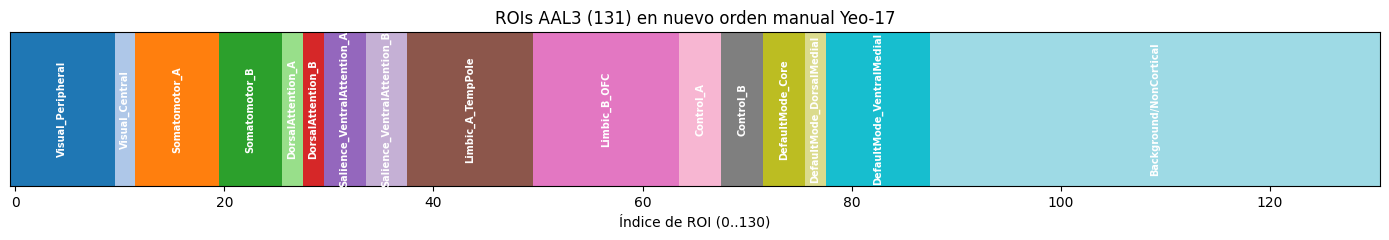

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_map = pd.read_csv(fem.AAL3_MANUAL_NETWORK_MAPPING_CSV)

net_col_candidates = ["Yeo17_Network_manual", "Yeo17_Network", "NetworkName", "Network"]
net_col = next((c for c in net_col_candidates if c in df_map.columns), None)
if net_col is None:
    raise ValueError(f"No pude encontrar columna de nombre de red entre: {net_col_candidates}")

networks = df_map[net_col].values
unique_networks = list(dict.fromkeys(networks))  # preserva orden de aparición
net_to_int = {net: i for i, net in enumerate(unique_networks)}
network_colors = [net_to_int[n] for n in networks]

plt.figure(figsize=(14, 2.5))
plt.imshow([network_colors], aspect="auto", cmap="tab20")
plt.yticks([])
plt.xlabel("Índice de ROI (0..130)")
plt.title("ROIs AAL3 (131) en nuevo orden manual Yeo-17")

for net in unique_networks:
    idx = np.where(networks == net)[0]
    if len(idx) == 0:
        continue
    center = np.mean(idx)
    plt.text(center, 0, net, rotation=90, ha="center", va="center",
             fontsize=7, color="white", fontweight="bold")

plt.tight_layout()
plt.show()


In [5]:
from importlib import reload

reload(fem)

print("=== RESUMEN ANTES DE CORRER main() ===")
print("FINAL_N_ROIS_EXPECTED:", fem.FINAL_N_ROIS_EXPECTED)
print("OUTPUT_CONNECTIVITY_DIR_NAME:", fem.OUTPUT_CONNECTIVITY_DIR_NAME)
print("CONNECTIVITY_CHANNEL_NAMES:", fem.CONNECTIVITY_CHANNEL_NAMES)
print("ROI reordering activo?:",
      "Sí" if fem.AAL3_ROI_ORDER_MAPPING and fem.AAL3_ROI_ORDER_MAPPING.get("new_order_indices") is not None else "No")

# ⚠️ Esto dispara todo el pipeline (multiprocessing, etc.).
fem.main()


2026-01-02 16:29:17,205 - INFO - feature_extraction_manual.py:54 - Successfully imported 'threshold_omst_global_cost_efficiency' from 'dyconnmap.graphs.threshold' and aliased as 'orthogonal_minimum_spanning_tree'.
2026-01-02 16:29:17,206 - INFO - feature_extraction_manual.py:188 - Global MAX_WORKERS for ProcessPoolExecutor set to: 6 (based on 12 total cores)
2026-01-02 16:29:17,206 - INFO - feature_extraction_manual.py:447 - --- Initializing AAL3 ROI Processing Information ---
2026-01-02 16:29:17,211 - INFO - feature_extraction_manual.py:486 - AAL3 ROI processing info initialized (prior to reordering attempt):
2026-01-02 16:29:17,211 - INFO - feature_extraction_manual.py:487 -   Indices of 4 AAL3 systemically missing ROIs (0-based, from 170): [34, 35, 80, 81]
2026-01-02 16:29:17,212 - INFO - feature_extraction_manual.py:488 -   Number of ROIs in AAL3 meta after excluding systemically missing: 166 (Expected: 166)
2026-01-02 16:29:17,212 - INFO - feature_extraction_manual.py:489 -   Indi

=== RESUMEN ANTES DE CORRER main() ===
FINAL_N_ROIS_EXPECTED: 131
OUTPUT_CONNECTIVITY_DIR_NAME: AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned
CONNECTIVITY_CHANNEL_NAMES: ['Pearson_OMST_GCE_Signed_Weighted', 'Pearson_Full_FisherZ_Signed', 'MI_KNN_Symmetric', 'dFC_AbsDiffMean', 'dFC_StdDev', 'DistanceCorr', 'Granger_F_lag1']
ROI reordering activo?: Sí


Processing Subjects:   0%|          | 0/431 [00:00<?, ?it/s]2026-01-02 16:29:17,515 - INFO - feature_extraction_manual.py:711 - S 002_S_0685: Reordenando series temporales de ROIs ((140, 131)) según el nuevo orden de redes (longitud de índices: 131).
2026-01-02 16:29:17,515 - INFO - feature_extraction_manual.py:711 - S 002_S_2010: Reordenando series temporales de ROIs ((140, 131)) según el nuevo orden de redes (longitud de índices: 131).
2026-01-02 16:29:17,516 - INFO - feature_extraction_manual.py:711 - S 002_S_0295: Reordenando series temporales de ROIs ((140, 131)) según el nuevo orden de redes (longitud de índices: 131).
2026-01-02 16:29:17,517 - INFO - feature_extraction_manual.py:888 - S 002_S_0685: Preprocessing. Input TPs: 140, ROIs: 131 (should be 131), TR: 3.0s. Target TPs for output: 140.
2026-01-02 16:29:17,516 - INFO - feature_extraction_manual.py:711 - S 002_S_0729: Reordenando series temporales de ROIs ((140, 131)) según el nuevo orden de redes (longitud de índices: 131)

In [6]:
import numpy as np
from pathlib import Path

output_dir = fem.BASE_PATH_AAL3 / fem.OUTPUT_CONNECTIVITY_DIR_NAME
global_npz_path = next(output_dir.glob("GLOBAL_TENSOR_from_*.npz"))
print("GLOBAL_TENSOR path:", global_npz_path)

with np.load(global_npz_path) as data:
    G = data["global_tensor_data"]     # (N_subjects, N_channels, 131, 131)
    subs = data["subject_ids"]
    chans = data["channel_names"]
    roi_order_name = data["roi_order_name"]
    roi_names = data["roi_names_in_order"]
    net_labels = data["network_labels_in_order"]

print("GLOBAL_TENSOR shape:", G.shape)
print("Canales:", chans)
print("ROI order name:", roi_order_name)
print("Primeras 10 ROIs en orden global:")
for i in range(10):
    print(f"{i:3d} {roi_names[i]:25s} → {net_labels[i]}")


GLOBAL_TENSOR path: /home/diego/proyectos/betavae-xai-ad/data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz
GLOBAL_TENSOR shape: (431, 7, 131, 131)
Canales: ['Pearson_OMST_GCE_Signed_Weighted' 'Pearson_Full_FisherZ_Signed'
 'MI_KNN_Symmetric' 'dFC_AbsDiffMean' 'dFC_StdDev' 'DistanceCorr'
 'Granger_F_lag1']
ROI order name: aal3_manual_yeo17_order
Primeras 10 ROIs en orden global:
  0 Cuneus_L                  → Visual_Peripheral
  1 Fusiform_L                → Visual_Peripheral
  2 Lingual_L                 → Visual_Peripheral
  3 Occipital_Inf_L           → Visual_Peripheral
  4 Occipital_Sup_L           → Visual_Peripheral
  5 Cuneus_R                  → Visual_Peripheral
  6 Fusiform_R                → Visual_Peripheral
  7 Lingual_R                

📂 Carpeta analizada: AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned
📄 Cargando: GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz ...

✅ Tensor Cargado Exitosamente
   Dimensiones: (431, 7, 131, 131)
   Sujetos: 431
   Canales: 7


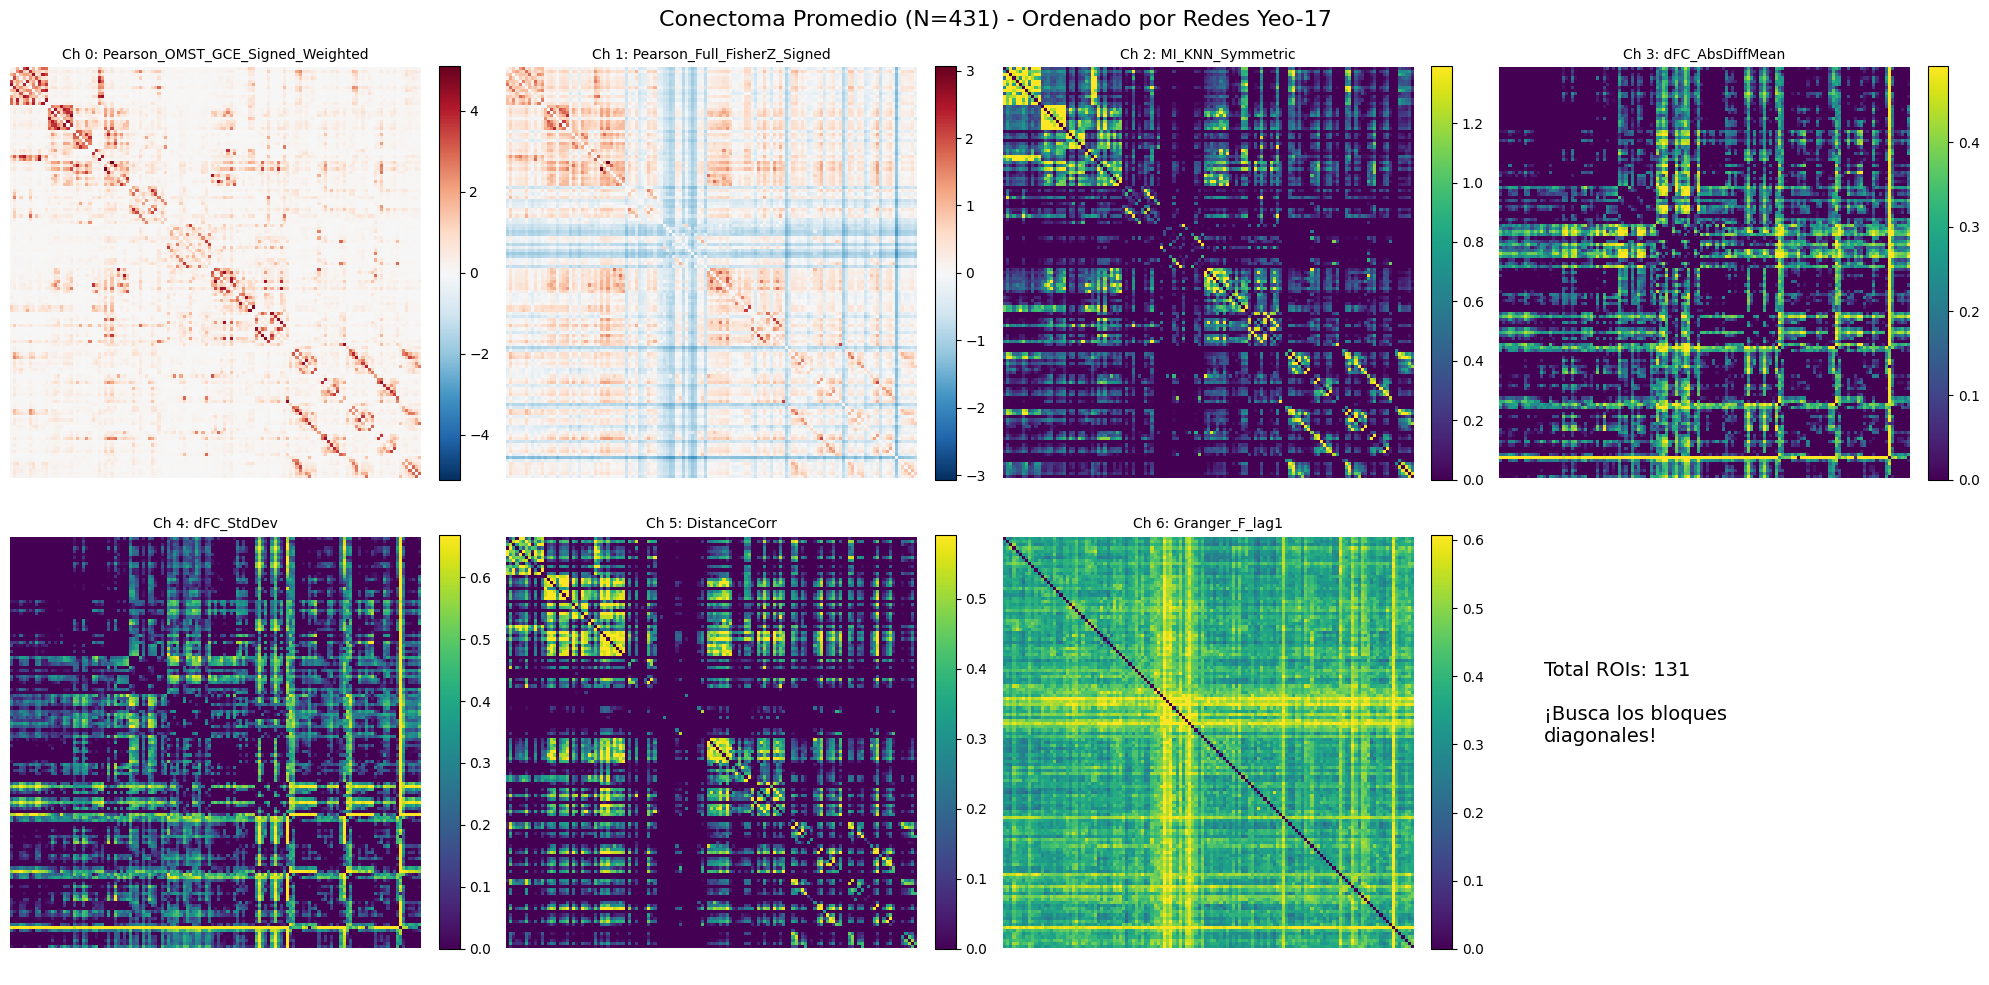

Interpretación Visual:
- Canales Pearson: Deberías ver cuadrados rojos/azules definidos a lo largo de la diagonal.
- Canal OMST: Debería verse como una red dispersa (pocos puntos fuertes).
- Si ves bloques diagonales, el reordenamiento Yeo-17 funcionó.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# 1. Configurar ruta
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"

# 2. Encontrar la carpeta de resultados más reciente
# El script creó una carpeta que empieza con "AAL3_dynamicROIs_..."
results_dirs = sorted(list(DATA_DIR.glob("AAL3_dynamicROIs_*")), key=os.path.getmtime, reverse=True)

if not results_dirs:
    print("❌ No se encontraron carpetas de resultados en data/.")
else:
    latest_dir = results_dirs[0]
    print(f"📂 Carpeta analizada: {latest_dir.name}")
    
    # 3. Cargar el Tensor Global
    global_files = list(latest_dir.glob("GLOBAL_TENSOR*.npz"))
    
    if global_files:
        tensor_path = global_files[0]
        print(f"📄 Cargando: {tensor_path.name} ...")
        
        data = np.load(tensor_path)
        # El tensor tiene forma (Sujetos, Canales, ROIs, ROIs)
        global_tensor = data['global_tensor_data'] 
        channel_names = data['channel_names']
        subject_ids = data['subject_ids']
        roi_names = data['roi_names_in_order']
        
        print(f"\n✅ Tensor Cargado Exitosamente")
        print(f"   Dimensiones: {global_tensor.shape}")
        print(f"   Sujetos: {len(subject_ids)}")
        print(f"   Canales: {len(channel_names)}")

        # 4. VISUALIZACIÓN: El "Cerebro Promedio"
        # Promediamos todos los sujetos para ver la estructura general de las redes
        mean_connectome = np.mean(global_tensor, axis=0)
        
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.flatten()
        
        fig.suptitle(f"Conectoma Promedio (N={len(subject_ids)}) - Ordenado por Redes Yeo-17", fontsize=16)
        
        for i, ch_name in enumerate(channel_names):
            matrix = mean_connectome[i]
            
            # Ajuste de color: Divergente para Pearson, Secuencial para otros
            if "Pearson" in ch_name:
                cmap = 'RdBu_r'
                vmax = np.max(np.abs(matrix))
                vmin = -vmax
            else:
                cmap = 'viridis' # O 'magma' para Granger
                vmin = 0
                vmax = np.percentile(matrix, 98) # Saturar al 98% para ver contraste
            
            im = axes[i].imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax, origin='upper')
            axes[i].set_title(f"Ch {i}: {ch_name}", fontsize=10)
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
            axes[i].axis('off')
            
        # Ocultar el último subplot vacío (son 7 canales, 8 espacios)
        axes[7].axis('off')
        axes[7].text(0.1, 0.5, f"Total ROIs: {len(roi_names)}\n\n¡Busca los bloques\ndiagonales!", fontsize=14)
        
        plt.tight_layout()
        plt.show()
        
        print("Interpretación Visual:")
        print("- Canales Pearson: Deberías ver cuadrados rojos/azules definidos a lo largo de la diagonal.")
        print("- Canal OMST: Debería verse como una red dispersa (pocos puntos fuertes).")
        print("- Si ves bloques diagonales, el reordenamiento Yeo-17 funcionó.")
        
    else:
        print("❌ No se encontró el archivo .npz dentro de la carpeta.")

In [6]:
import numpy as np
# Carga los datos primero
data = np.load('/home/diego/proyectos/betavae-xai-ad/data/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz')
roi_names = data['roi_names_in_order'] # Aquí es donde se define

In [7]:
import numpy as np

roi = np.array(roi_names)  # roi_names_in_order del npz
# distancia entre L y R para mismo basename (si tu naming lo permite)
def base(x): 
    return x.replace("_L","").replace("_R","")

idx = {name:i for i,name in enumerate(roi)}
pairs = []
for name in roi:
    if name.endswith("_L"):
        r = name[:-2] + "_R"
        if r in idx:
            pairs.append(abs(idx[name]-idx[r]))

print("n pares:", len(pairs))
print("distancia mediana L-R:", np.median(pairs))
print("distancia min/max:", np.min(pairs), np.max(pairs))


n pares: 61
distancia mediana L-R: 5.0
distancia min/max: 1 18
